![for sale image, from https://time.com/5835778/selling-home-coronavirus/](https://api.time.com/wp-content/uploads/2020/05/selling-home-coronavirus.jpg?w=800&quality=85)

# Tin Consulting: Kings County Home Analysis

## Overview

This project analyzes sales data from Kings County, Washington. The goal is to build a model that reasonably accurately predicts change in home prices and helps inform actionable business recommendations for our stakeholder. This notebook contains sections for (1) exploratory data analysis / understanding (2) data cleaning and (3) modeling. We will use multiple linear regression as our main modelling tool.

## Business Problem

- Our stakeholder is a small-time property developer / real estate firm that is looking to expand its presence in Kings County
- Historically, they've primarily operated out of state, and are unfamiliar with the local dynamics of this real estate market.
- They've asked us to help determine some of the key drivers of changes in home price in this key market.
- Given this ask, we will look for meaningful predictors that will help the developer focus their efforts on homes that will sell for more.
- This is important as it allows the developer to avoid wasting time or money on buying / developing properties with features that are unlikely to change the home price materially.

## Data Understanding

- The data represents ~22K home sales in Kings County, Washington from September 2014 through January 2015
- The data includes the sale price of the home and a number of descriptors, including many variables about size (number of rooms, square footage, lot size), location (zip code, lat / lon), and other attributes (waterfront, basement, etc).
- The key target variable will be sale price of the home.
- For our model, we will testing which features of the house (or combinations of features) has (1) the most predictive value for home price and (2) is a meangingful contributor to changes in home price (coefficient)
- In addition to home features, we will also incorporate a geographic analysis by neighborhood

In [33]:
# Standard imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder

# Import functions to run and evaluate regression models
from util import run_model, evaluate_model, high_corr

# Pandas options
pd.set_option('display.max_columns', None)

# Set style
plt.style.use('seaborn')

In [2]:
# Import data

df_sales = pd.read_csv('./Data/kc_house_data.csv')

### Initial Data Summary
- Summary: all are numbers except Date and Basement_sqft. The latter should probably be converted to a number.
- Some of the numbers are likely categorical and need to be treated as such.
- 22K entries total. Most columns do not contain nulls (will need to clean up waterfront and yr_renovated)

In [3]:
# Run info to check for general data types and nulls

df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

### Numeric Data Exploration

- This section will review the numeric variables in the dataset
- Initial review will cover normality, outliers, and relationship with Price

In [4]:
df_num = df_sales.select_dtypes(include=['float64', 'int64'])

y = df_num['price']
X = df_num.drop(columns=['price','id', 'lat', 'long'], axis=1)

#### Normality Check
Conclusions:
- Transform bedrooms and bathrooms into categorical variables
- Log transform sqft_living to help normalize
- Check for collinearity among the "size" metrics
- Transform floors to a categorical variable
- Make condition a categorical by 4+ as good condition
- Keep grade as a continuous variable

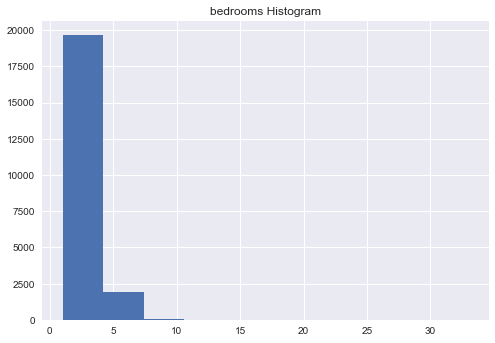

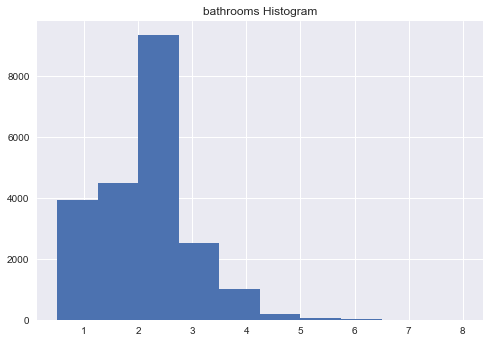

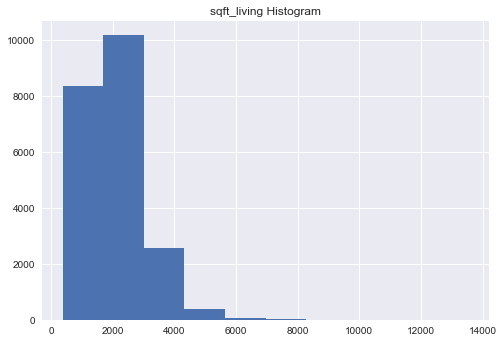

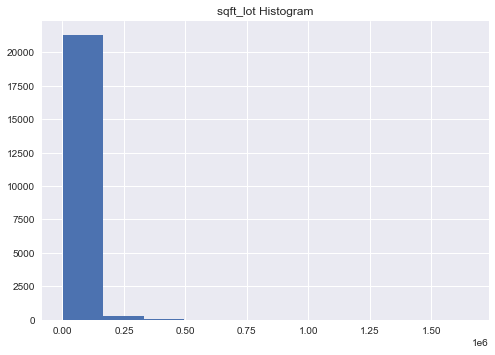

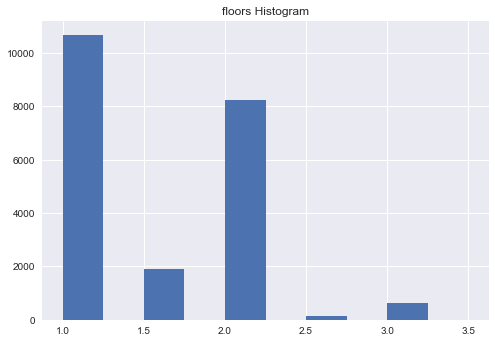

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


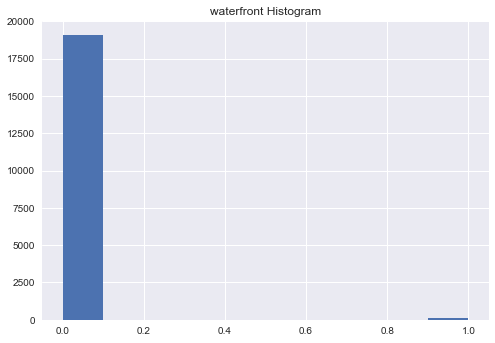

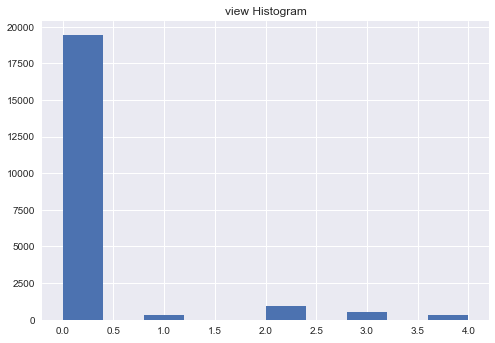

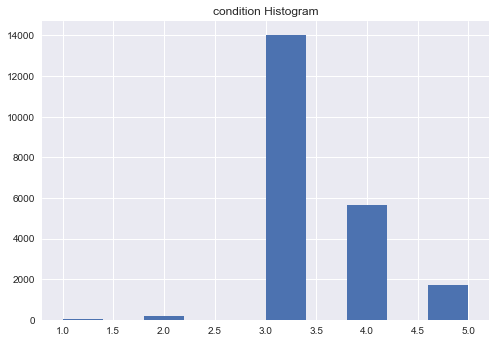

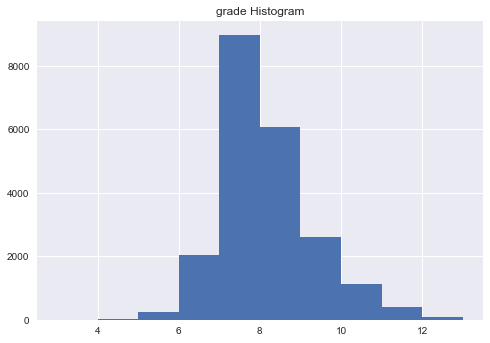

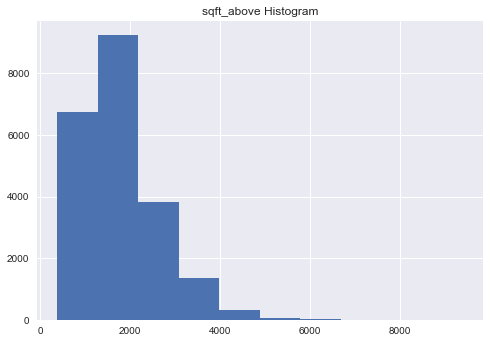

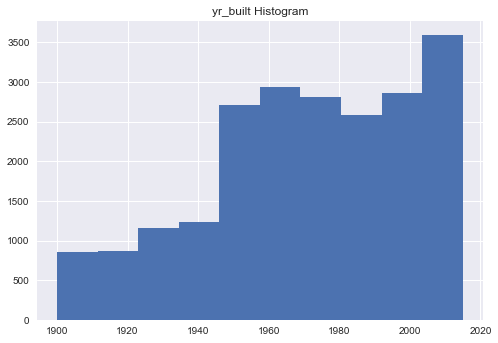

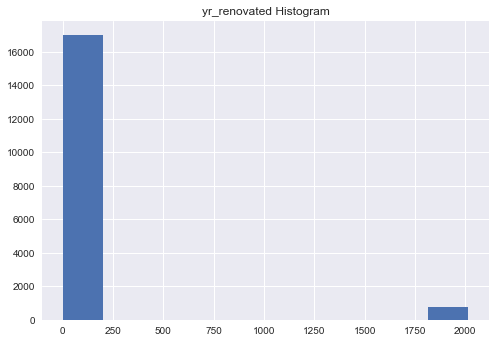

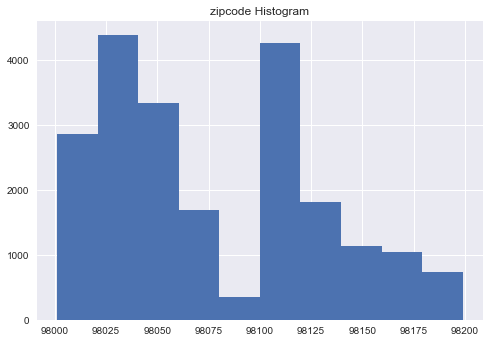

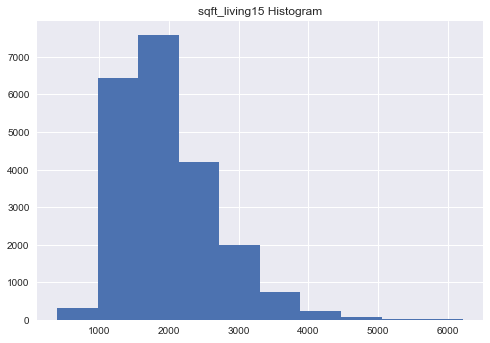

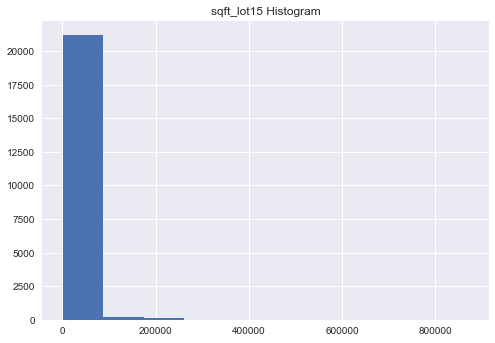

In [5]:
# Check for normality

for col in X.columns:
    plt.hist(X[col])
    plt.title(f"{col} Histogram")
    plt.show();

#### Linear Relationship Check

Conclusions:
- Categoricals are difficult to gauge. Will need to test those in the model
- Grade and Living Area have strongest positive relationship
- Possible positive relationship with bathrooms as well
- Plotting sales vs itself shows some outliers. Rather than cut off our Y variable, we could narrow down the scope by more strictly defining our business problem.

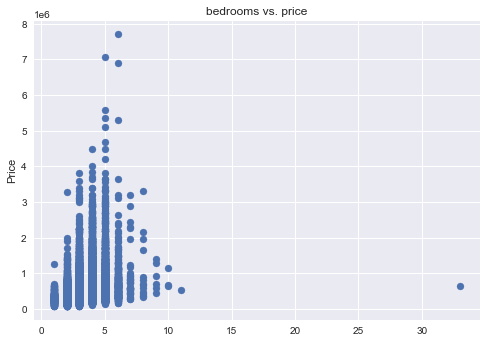

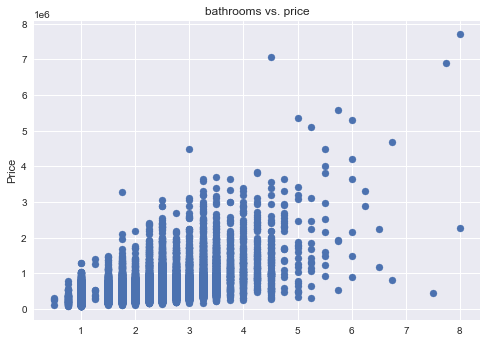

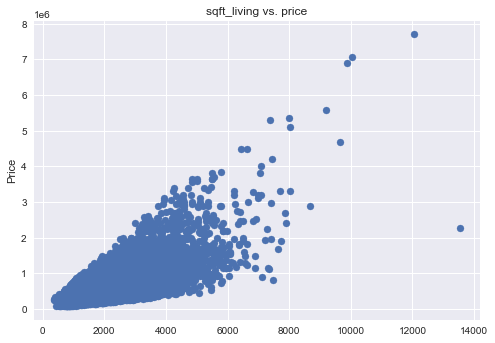

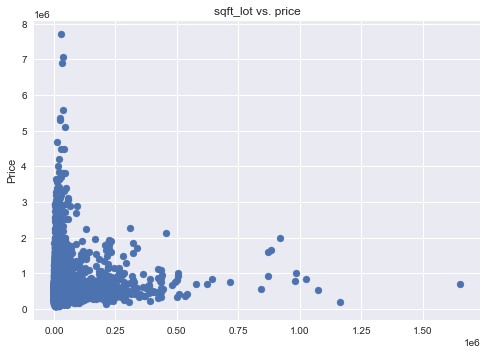

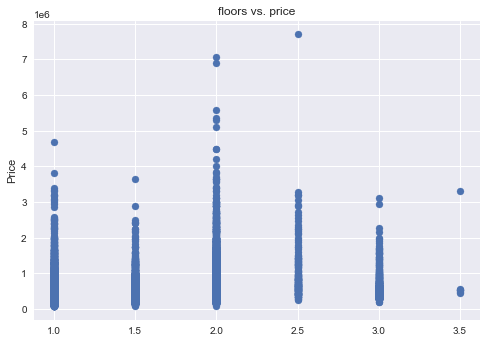

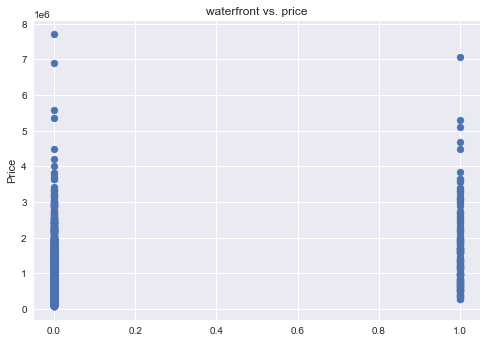

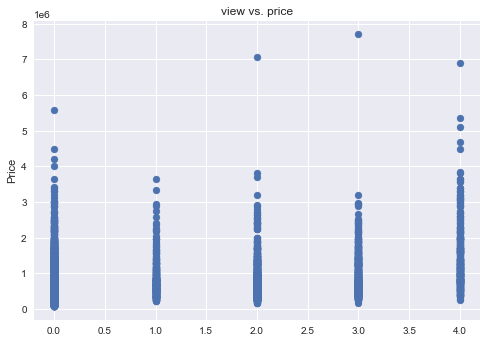

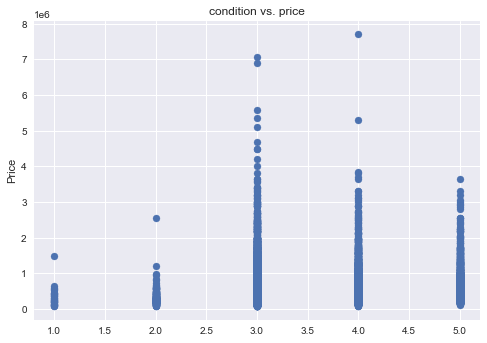

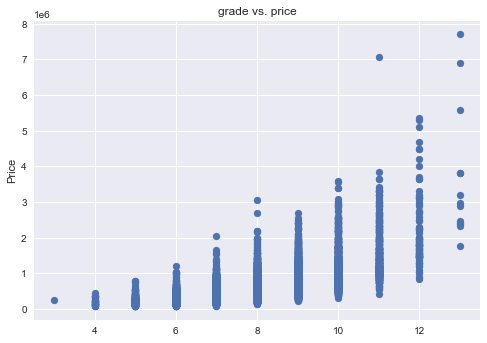

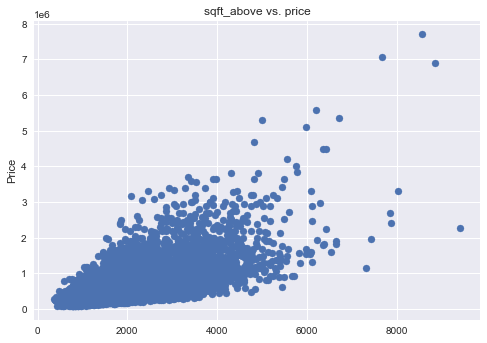

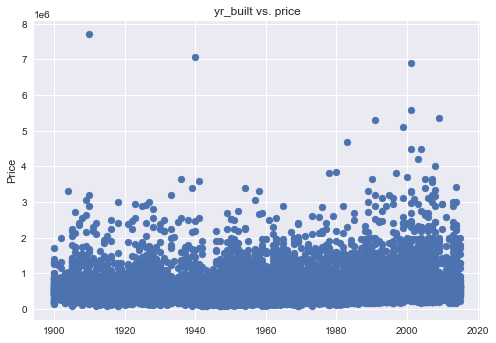

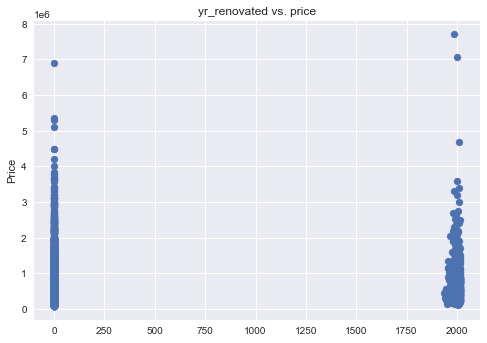

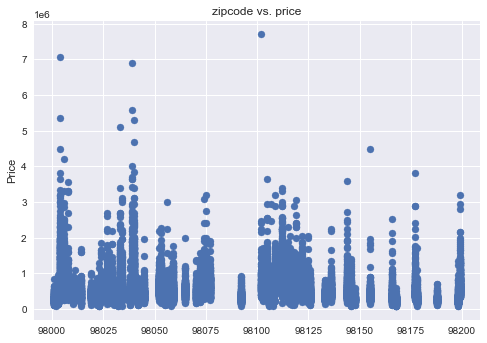

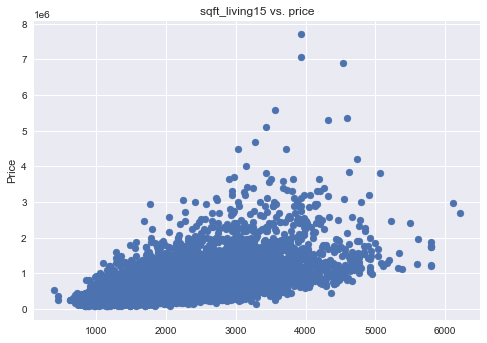

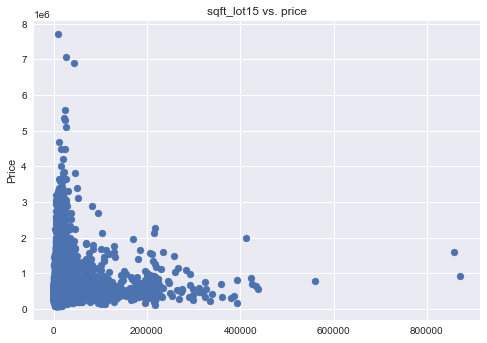

In [6]:
# Check for linear relationship between numbers and sales

for col in X.columns:
    plt.scatter(X[col], y)
    plt.title(f"{col} vs. price")
    plt.ylabel("Price")
    plt.show();

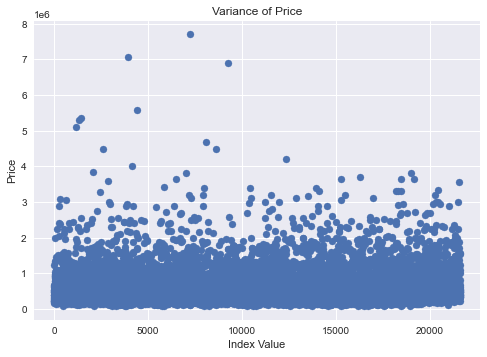

In [7]:
# also plot sales against itself
plt.scatter(y.index, y)
# plt.hlines(y.mean(), 0, 3000000)
plt.xlabel('Index Value')
plt.ylabel('Price')
plt.title('Variance of Price')
plt.show()

# There are some outliers in price. This can be narrowed down by limiting the scope of our business problem.

### Potential categorical variable exploration

We may transform some of the below into categorical variables if there's a business reason (i.e., high bedroom or bathroom count, multi story, etc).

Conclusions:
- Obvious outlier in bedrooms.
- No obvious relationship with floors at price, may want to make a "multi-story" categorical

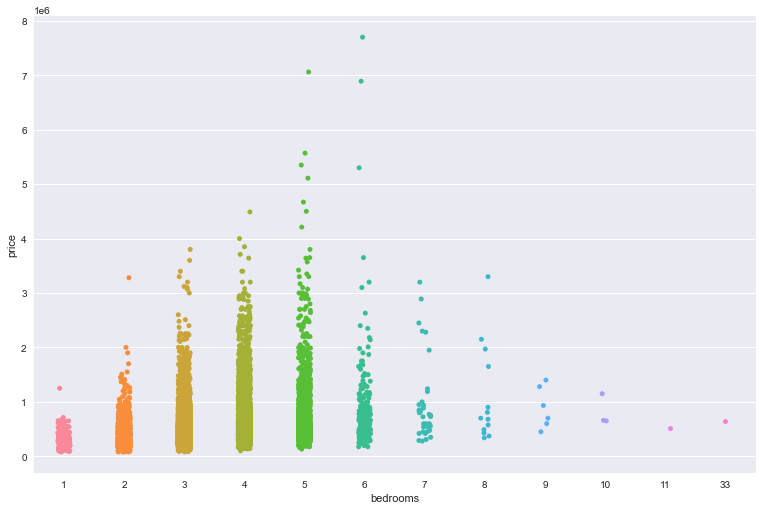

In [8]:
# Perhaps adding value the more bedrooms you add, up to about 5. Obvious outliers

sns.catplot(x='bedrooms', y='price', data=df_sales, height=7, aspect=1.5);

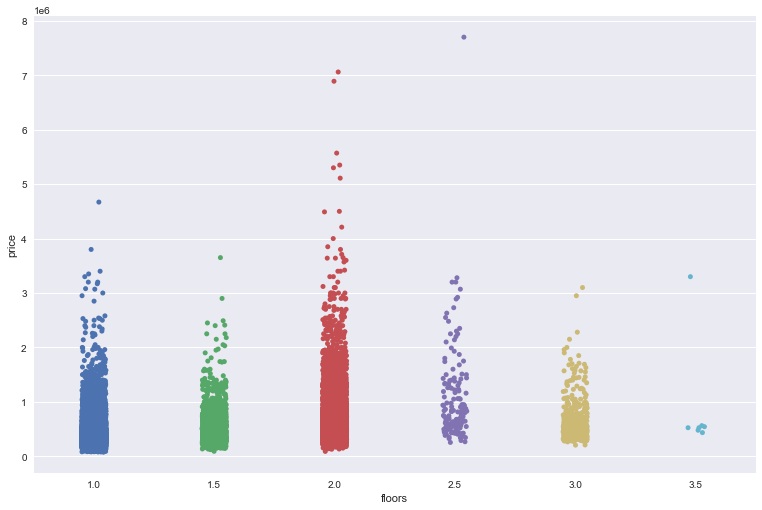

In [9]:
# Homes with two flors seem to have more homes with a higher price

sns.catplot(x='floors', y='price', data=df_sales, height=7, aspect=1.5);

#### Non-numeric data exploration

Conclusions:
- Date is unlikely to be useful. Only covers September 2014 - January 2015. Not enough time for a temporal analysis
- Sq foot basement needs to be converted to int. Can also create a categorical, "has_basement"

In [10]:
# This dataset contains home sales from September 2014 through January 2015.

latest_date = df_sales['date'].min()
earliest_date = df_sales['date'].max()

sorted_date = df_sales['date'].sort_values(ascending=False)

print(earliest_date, latest_date)

9/9/2014 1/10/2015


In [11]:
# There are 304 unique values here. 12K of them are 0. 
# Two steps:
# Converted to numerical
# Used to create a new binary categorical variable "has_basement"

print(len(df_sales['sqft_basement'].unique()))
(df_sales['sqft_basement'] == '0.0').sum()

304


12826

### Outliers

- On first glance, there appear to be outliers among bedrooms, sq footage, and grade
- Bedrooms: this is a data error. We will control for this by cutting off num of bedrooms to focus only on single-family homes
- Sq footage: outliers, but likely no data issues. We will narrow scope of this by filtering for properties that are a reasonable size for "single-family" homes only
- Grade: no outliers! Checked on King's County website and the grade truly goes up to 13.

In [12]:
df_sales.describe().apply(lambda s: s.apply('{0:.0f}'.format))

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597,21597,21597,21597,21597,21597,21597,19221,21534,21597,21597,21597,21597,17755,21597,21597,21597,21597,21597
mean,4580474288,540297,3,2,2080,15099,1,0,0,3,8,1789,1971,84,98078,48,-122,1987,12758
std,2876735716,367368,1,1,918,41413,1,0,1,1,1,828,29,400,54,0,0,685,27274
min,1000102,78000,1,0,370,520,1,0,0,1,3,370,1900,0,98001,47,-123,399,651
25%,2123049175,322000,3,2,1430,5040,1,0,0,3,7,1190,1951,0,98033,47,-122,1490,5100
50%,3904930410,450000,3,2,1910,7618,2,0,0,3,7,1560,1975,0,98065,48,-122,1840,7620
75%,7308900490,645000,4,2,2550,10685,2,0,0,4,8,2210,1997,0,98118,48,-122,2360,10083
max,9900000190,7700000,33,8,13540,1651359,4,1,4,5,13,9410,2015,2015,98199,48,-121,6210,871200


In [13]:
# There appear to be outliers in 'bedrooms', 'grade', and 'sqft_lot' based on max values

# Bedroom outlier check
bedroom_outlier = df_sales[df_sales['bedrooms'] == 33]

bedroom_outlier

# Conclusion: seems to be a typo. Filter for everything with fewer than 8 bedrooms as our developer is 
# unlikely to want to build these properties

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


In [14]:
# Grade outlier check

df_sales['grade'].value_counts()

# Conclusion: not actually an outlier. Grades go up to 13 and indicate the quality of materials used.

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

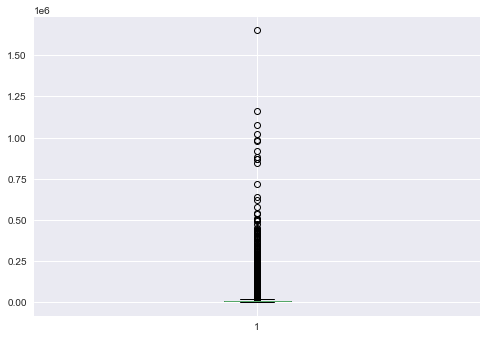

In [15]:
# Sqft_lot check

fig, ax = plt.subplots()

ax.boxplot(df_sales['sqft_lot']);


# Conclusion: while possible a valid entry, 1.6mm square feet converts to 38 acres.
# The developer is unlikely to consider building on property more than a few acres large.
# Can probably apply a filter of 200K square feet for lot size (~4.5 acres). This covers 99% of the dataset

### Null values

Exploring null values and approach for dealing with them.

Conclusions:
- Null values present in Waterfront, View, and Yr_renovated
- Waterfront: this is a binary variable. Overwhelming tendency in dataset towards 0 (no waterfront) so will replace nulls with the most common value.
- Yr_renovated: likewise, most (17k) entries have 0, meaning not renovated. Will replace null values with 0
- View: Again, overwhelming tendency towards 0. Given only 63 null entries, makes a lot of sense to replace with 0

In [16]:
df_sales.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [17]:
# View
# Conclusion: Given the overwhelming tendency towards 0, replace the null values with 0

df_sales['view'].value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [18]:
# Waterfront
# Conclusion: replace these nulls with 0 given overwhelming tendency in that direction

df_sales['waterfront'].value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [20]:
# yr_renovated
# Conclusion: null values here probably mean the home hasn't been renovated, replace with zero.

df_sales['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [21]:
# Most nulls in yr_renovated were built relatively recently and are unlikely to have been renovated

df_sales[df_sales['yr_renovated'].isna()]['yr_built'].value_counts()

2014    102
1977     77
2003     77
2008     75
2006     73
       ... 
1902      6
1901      6
1934      5
1936      5
1904      4
Name: yr_built, Length: 116, dtype: int64

## Data Preparation

Data cleaning steps:

- Outliers: Null values for views, waterfront, and yr_renovated were replaced with the most common value. This seemed most appropriate given relative infrequency of the nulls and overwhelming occurance of the most common value
- Thresholds were set to control for outliers and narrow the scope of the business problem. Since we're working for a smaller developer that is only focused on single family homes, we made a number of adjustments to the dataset. 
- Bedrooms: filtered only for homes with 5 or fewer bedrooms as a proxy for single family
- Sq ft of lot: filtered for under 4.5 acres. Anything above this amount seems unrealistic for a small property developer to want to acquire for single family homes in a major urban area.
- Neighborhoods: removed Medina and Mercer Island. These had outsized home prices relative to average. Medina is where several billionaires like Bill Gates and Jeff Bezos live. These are not realistic neighborhoods for our property developer to want to enter.

In [22]:
sales_clean = df_sales.copy()

### Null values

- Replacing view, waterfront, and yr_renovated with their most common value

In [23]:
# Replace nulls in view, yr_renovated, and waterfront with its most common value

from sklearn.impute import SimpleImputer

columns_to_replace = ['view', 'yr_renovated', 'waterfront']

for col in columns_to_replace:
    imputer = SimpleImputer(strategy='most_frequent')
    to_impute = sales_clean[[col]]
    col_imputed = imputer.fit_transform(to_impute)
    sales_clean[col] = col_imputed

### Convert dtype in sqft basement to int

In [24]:
sales_clean['sqft_basement'].loc[sales_clean['sqft_basement'] == '?'] = 0
sales_clean['sqft_basement'] = sales_clean['sqft_basement'].apply(lambda x: float(x))

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### Create categorical variables

- Created these categoricals to aid in business understanding, might not use in the final model
- For example, do we care whether the home is 2 vs. 3 floors or primarily that it is multi story?
- One hot encode zipcodes as columns and map to a neighborhood

In [25]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [26]:
recent_build = 2005

# Was the house built after the year defined above (1) or not (0)
sales_clean['recent_build'] = 0
sales_clean['recent_build'].loc[sales_clean['yr_built'] >= recent_build] = 1


# Has the house been renovated (1) or not (0)
sales_clean['is_renovated'] = 0
sales_clean['is_renovated'].loc[sales_clean['yr_renovated'] != 0] = 1

In [27]:
# Add categorical for 1.5 floors or greater

floor_list = []
for i in sales_clean['floors']:
    if i > 1.0:
        floor_list.append(1)
    else:
        floor_list.append(0)
        
sales_clean['multi_story'] = floor_list

In [28]:
# Add categorical for 2 floors or greater

floor_list2 = []
for i in sales_clean['floors']:
    if i >= 2.0:
        floor_list2.append(1)
    else:
        floor_list2.append(0)
        
sales_clean['two_or_more_stories'] = floor_list2

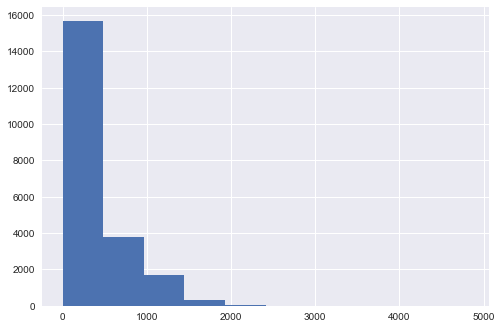

In [29]:
plt.hist(sales_clean['sqft_basement']);

In [30]:
# Add categorical for has a basement or not

basement_list = []
for i in sales_clean['sqft_basement']:
    if i == 0:
        basement_list.append(0)
    else:
        basement_list.append(1)

sales_clean['basement'] = basement_list

In [31]:
# Create bathroom / bedroom categoricals based on size

bathroom_threshold = 3
bedroom_threshold = 4

sales_clean['high_bathrooms'] = 0
sales_clean['high_bathrooms'].loc[sales_clean['bathrooms'] >= bathroom_threshold] = 1

sales_clean['high_bedrooms'] = 0
sales_clean['high_bedrooms'].loc[sales_clean['bedrooms'] >= bedroom_threshold] = 1

In [32]:
# Function for zip code categoricals

zipcodes = []
def zipcode_encoder(df):
    for i in list(set(df['zipcode'])):
        sales_clean.loc[sales_clean['zipcode'] == i, 'zip_' + str(i)] = 1
        sales_clean.loc[sales_clean['zipcode'] != i, 'zip_' + str(i)] = 0
        
        zipcodes.append('zip_' + str(i))

zipcode_encoder(sales_clean)

In [34]:
# Add zip code categorical to data frame

sales_clean =  pd.concat([sales_clean, zipcode_encoder(sales_clean)], axis=1)

In [35]:
# Append neighborhood categories

zipcode_dict = {98002: 'Auburn',98092: 'Auburn',98224: 'Baring',98004: 'Bellevue',98005: 'Bellevue',
98006: 'Bellevue',98007: 'Bellevue',98008: 'Bellevue',98010: 'Black_Diamond',98011: 'Bothell',
98178: 'Bryn_Mawr_Skyway',98148: 'Burien',98166: 'Burien',98014: 'Carnation',98077: 'Cottage_Lake',
98042: 'Covington',98198: 'Des_Moines',98019: 'Duvall',98031: 'East_Hill_Meridian',98022: 'Enumclaw',
98058: 'Fairwood',98024: 'Fall_City',98003: 'Federal_Way',98023: 'Federal_Way',98027: 'Issaquah',
98029: 'Issaquah',98028: 'Kenmore',98032: 'Kent',98030: 'Kent',98033: 'Kirkland',98034: 'Kirkland',
98001: 'Lakeland_North',98038: 'Maple_Valley',98039: 'Medina',98040: 'Mercer_Island',98045: 'North_Bend',
98047: 'Pacific',98050: 'Preston',98051: 'Ravensdale',98052: 'Redmond',98055: 'Renton',98056: 'Renton',
98057: 'Renton',98059: 'Renton',98074: 'Sammamish',98075: 'Sammamish',98188: 'SeaTac',98199: 'Seattle',
98174: 'Seattle',98154: 'Seattle',98158: 'Seattle',98164: 'Seattle',98101: 'Seattle',98102: 'Seattle',
98103: 'Seattle',98104: 'Seattle',98105: 'Seattle',98106: 'Seattle',98107: 'Seattle',98108: 'Seattle',
98109: 'Seattle',98112: 'Seattle',98115: 'Seattle',98116: 'Seattle',98117: 'Seattle',98118: 'Seattle',
98119: 'Seattle',98121: 'Seattle',98122: 'Seattle',98125: 'Seattle',98126: 'Seattle',98133: 'Seattle',
98134: 'Seattle',98136: 'Seattle',98144: 'Seattle',98155: 'Shoreline',98177: 'Shoreline',98288: 'Skykomish',
98065: 'Snoqualmie',98168: 'Tukwila',98053: 'Union_Hill_Novelty_Hill',98195: 'Univ_Of_Washington',
98070: 'Vashon',98146: 'White_Center',98072: 'Woodinville'}


for i in zipcode_dict.keys():
    sales_clean.loc[sales_clean['zipcode'] == i, 'neighborhood'] = zipcode_dict[i] 

neighborhood_list = list(set(sales_clean['neighborhood']))

for i in neighborhood_list:
    sales_clean.loc[sales_clean['neighborhood'] == i, i] = 1
    sales_clean.loc[sales_clean['neighborhood'] != i, i] = 0

### Remove outliers

(Rationale explained above at the start of the data cleaning section)

In [36]:
# Set thresholds to filter dataset down for outliers
# Drop Medina and Mercer

max_bedrooms = 5
max_sq_ft = 200000
neighborhoods_to_drop = ['Medina', 'Mercer_Island']
zipcodes_to_drop = ['98039', '98040']
sales_clean = sales_clean[sales_clean['bedrooms'] <= max_bedrooms]
sales_clean = sales_clean[sales_clean['sqft_lot'] <= max_sq_ft]
sales_clean = sales_clean[(sales_clean['neighborhood'] != neighborhoods_to_drop[0]) &
                         (sales_clean['neighborhood'] != neighborhoods_to_drop[1])]


neighborhood_list.remove('Medina')
neighborhood_list.remove('Mercer_Island')

### Log scaling of variables to normalize

- Sq ft living and price are the most obvious non normal variables that we're likely to use
- Will potentially log scale more down the line

In [37]:
sales_clean['sqft_living_log'] = np.log(sales_clean['sqft_living'])
sales_clean['price_log'] = np.log(sales_clean['price'])

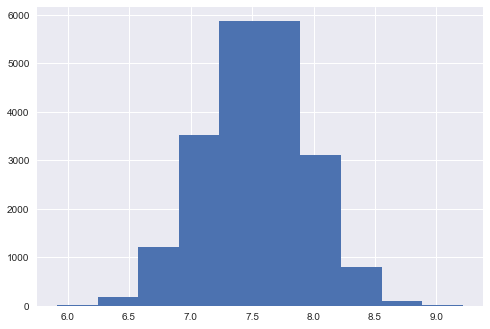

In [38]:
plt.hist(sales_clean['sqft_living_log']);

## Modeling

- Modeling started with a simple model that picked the feature that had the highest correlation with price, square footage of living space
- Iterations will add and subtract certain features to test effect on predictive value
- In addition, new interactive variables will be created based on business hypotheses to test effectiveness vs. price
- Rather than the "kitchen-sink" approach, we wanted variables that would be easy to understand for our stakeholder

### Side Note 1: Zip Code Regression Analysis

- Not shown below is extensive modeling done using zip codes (instead of neighborhoods)
- These models were the most accurate that we built, but were ultimately dropped in favor of more business interpretability
- Please refer to Jupyter notebook "Zip_code_analysis" in this same directory for a sample regression

### Side Note 2: Other models
- The below represents the summary of the models with the biggest step changes in variables or predictive power
- Additional models were run with various permutations of the below, but weren't necessarily worth calling out in the summary. Changes made were more of "tweaks".
- For detail on additional models run, see Notebooks/Jeff/Jeffs_notebook.ipynb

In [39]:
# Create the train and test datasets
from sklearn.model_selection import train_test_split

y = sales_clean['price']
X = sales_clean.drop(columns=['id','price'], axis=1)

# Split the data out, specifying size of the split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.20,
                                                    random_state=5
)

# Merge back together into one Train and Test dataset
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

### Baseline Understanding

- Model-less prediction is just taking the average home price across all observation
- This "prediction" is 216K off from the actual home price on average

In [46]:
# Linear reegression imports

from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics

# Other imports
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import statsmodels.api as sm

In [41]:
train_target_mean = y_train.mean()

baseline_train_preds = [train_target_mean] * len(y_train)
baseline_test_preds = [train_target_mean] * len(y_test)

# R squared
print('Model fit for training data')
print(f"R2: {metrics.r2_score(y_train, baseline_train_preds):.2f}")
# Mean squared error
print(f"MSE: {metrics.mean_squared_error(y_train, baseline_train_preds, squared=False):,.0f}")
# Mean absolute error
print(f"MAE: {metrics.mean_absolute_error(y_train, baseline_train_preds):,.0f}")
print("\n")

# R squared
print('Model fit for test data')
print(f"R2: {metrics.r2_score(y_test, baseline_test_preds):.2f}")
# Mean squared error
print(f"MSE: {metrics.mean_squared_error(y_test, baseline_test_preds, squared=False):,.0f}")
# Mean absolute error
print(f"MAE: {metrics.mean_absolute_error(y_test, baseline_test_preds):,.0f}")

Model fit for training data
R2: 0.00
MSE: 331,090
MAE: 216,687


Model fit for test data
R2: -0.00
MSE: 337,813
MAE: 219,914


### Simple model

- The first simple model tests price against it's most correlated feature, which is sqft_living
- This model actually produces a half decent result, with an R2 of 0.5, however, it violates many of the assumptions of linear regression

In util.py (imported) above, there are three functions:
- Run model: accepts train data, test data, a list of independent variables (column names), and False (regular price) or True (use log price as dependent). It returns the model summary and train / test predictions.
- Evaluate model: accepts same inputs as above, but prints a summary of key model output, include R2, RMSE, MAE, and residual plots (scatter and QQ)
- high_corr: accepts the list of column names and threshold between 0 and 1. Returns a series of all columns that have a correlation above the defined threshold. Used to check for multi-collinearity.

In [42]:
# Check for most correlated feature

df_train.corr().price.sort_values(ascending=False)

price              1.000000
price_log          0.901587
sqft_living        0.685284
grade              0.661800
sqft_living_log    0.603508
                     ...   
Federal_Way       -0.138685
zip_98039               NaN
zip_98040               NaN
Mercer_Island           NaN
Medina                  NaN
Name: price, Length: 135, dtype: float64

Train R2: 0.470
Test R2: 0.473
****
Train RMSE: 241,125
Test RMSE: 245,181
****
Train MAE: 162,913
Test MAE: 164,097

Residual scatter plot:


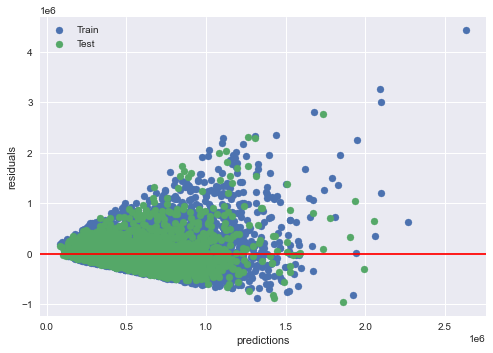



Residual qq plot


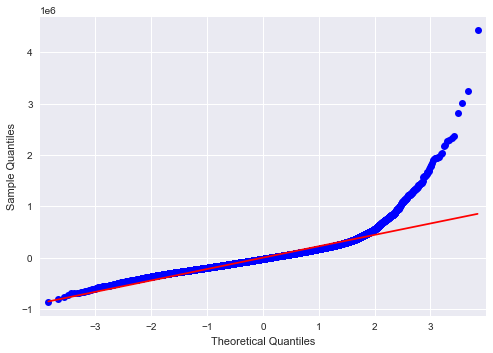

In [44]:
# Pass evaluate model False to use regular price. Pass True to use log price

evaluate_model(df_train, df_test, ['sqft_living'], False)

## Modeling Iterations
- These next models and features, or combinations of features to test impact on model
- General goal is to improve accuracy while maintaining interpretability
- We attempt to meet linear regression rules by log transforming variables when distribution is significantly "un-normal"

### Regression using log transformation of living area square feet and price
- First model uses log price and sqft living log
- Significantly improves performance across linear model assumptions
- R2 has actually declined

Train R2: 0.433
Test R2: 0.448
****
Train RMSE: 255,940
Test RMSE: 259,939
****
Train MAE: 159,942
Test MAE: 160,890

Residual scatter plot:


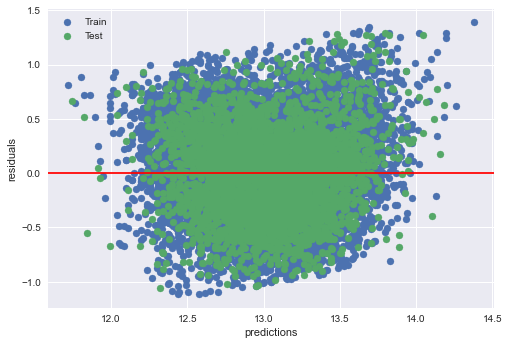



Residual qq plot


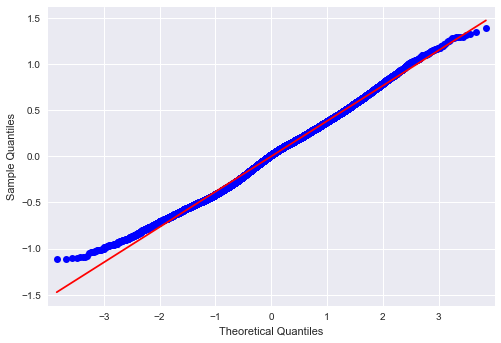

In [45]:
evaluate_model(df_train, df_test, ['sqft_living_log'], True)

### Replacing sqft living with other versions of size and other categoricals

- Model is back on par with the simple regression while generally adhering to linear regression rules
- Relationship is still relatively weak, sqft_living will need to be incorporated in some respect

Train R2: 0.506
Test R2: 0.516
****
Train RMSE: 229,882
Test RMSE: 232,612
****
Train MAE: 146,478
Test MAE: 147,406

Residual scatter plot:


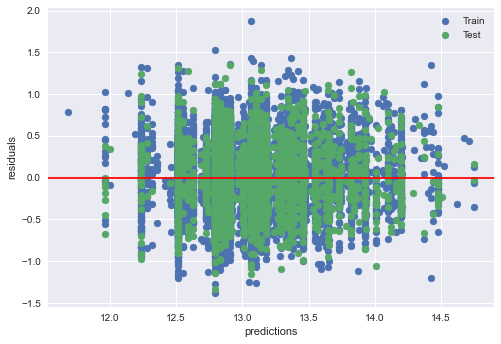



Residual qq plot


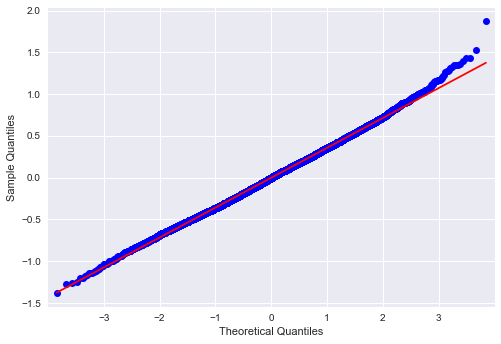

In [48]:
# Replace sqft_living_log with other versions of size

cols2 = ['high_bathrooms', 'high_bedrooms', 'multi_story', 'grade', 'recent_build', 'is_renovated']

model_output2, train_preds2, test_preds2 = run_model(df_train, df_test, cols2, True)

evaluate_model(df_train, df_test, cols2, True)

### Create new interactive variables and bring in neighborhood

- We wanted to test the effect of house size vs. property size. Bigger may seem to be better, but if a house is too big relative to its property size, does that actually decrease its value?
- This can also serve as another proxy for 'yard'. 
- Also wanted to break up year built into additional categoricals. Hypothesis is that older homes that are renovated may have significantly higher value than recent builds. This could lead to a recommendation to target older, un-renovated homes 
- One additional variable is bathrooms relative to bedrooms. What we wanted to test was whether increasing the number of bathrooms while holding bedrooms constant had an impact on price.

In [51]:
# Create new variable for sqft of ground floor vs. lot size. Log transform the result.
sales_clean['living_area_vs_lot'] = (sales_clean['sqft_above'] / sales_clean['floors']) / sales_clean['sqft_lot']
sales_clean['living_area_vs_lot'].loc[sales_clean['living_area_vs_lot'] >= 1] = 1
sales_clean['size_vs_lot_log'] = np.log(sales_clean['living_area_vs_lot'])

In [52]:
# New categorical variable, estimating whether a property has a yard or doesn't.
yard_threshold = 0.3
sales_clean['has_yard'] = 0
sales_clean['has_yard'].loc[sales_clean['living_area_vs_lot'] <= yard_threshold] = 1

In [50]:
# Create new variable for relative number of bathrooms vs. bedrooms
sales_clean['bath_vs_bed'] = sales_clean['bathrooms'] / sales_clean['bedrooms']
sales_clean['bath_vs_bed_log'] = np.log(sales_clean['bath_vs_bed'])

In [53]:
# New categorical variable for pre 1970, midcentury, or post war construction
sales_clean.drop(columns=['recent_build'], axis=1, inplace=True)

prewar = 1970
recent_build = 2010

sales_clean['pre_1970'] = 0 
sales_clean['mid_century'] = 0
sales_clean['recent_build'] = 0

sales_clean['pre_1970'].loc[sales_clean['yr_built'] < prewar] = 1
sales_clean['mid_century'].loc[(sales_clean['yr_built'] >= prewar) & (sales_clean['yr_built'] < recent_build)] = 1
sales_clean['recent_build'].loc[sales_clean['yr_built'] >= recent_build] = 1

In [54]:
# Interactive variable between pre_war and is_renovated

sales_clean['pre_1970_renovated'] = sales_clean['pre_1970'] * sales_clean['is_renovated']

In [55]:
# New train / test split based on the above changes

y = sales_clean['price']
X = sales_clean.drop(columns=['id','price'], axis=1)

# Split the data out, specifying size of the split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.20,
                                                    random_state=5
)

# Merge back together into one Train and Test dataset
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

### Testing neighborhoods and living_area_vs_lot size variable

- Adding neighborhoods appear to significantly add to the predictive capability of the model
- Living area vs. lot size (i.e., proxy for yard) appears to have a strong negative relationship with home price
- This seems to confirm our hypothesis that taking up more of the property with the house is not a good thing
- We chose to drop Snoqualmie from our neighborhood dummy variable set as it had the closest home price to average. Therefore, coefficients of neighborhood can be interpreted as relative to an average neighborhood
- Added in grade as it was one of the most correlated features previously

Train R2: 0.733
Test R2: 0.741
****
Train RMSE: 192,091
Test RMSE: 197,845
****
Train MAE: 107,806
Test MAE: 110,510

Residual scatter plot:


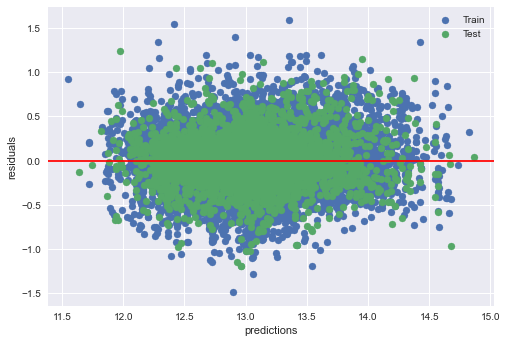



Residual qq plot


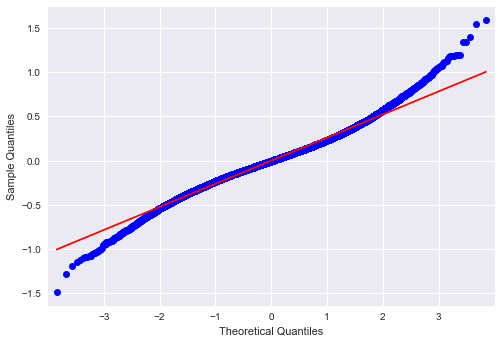

In [58]:
cols3 = ['high_bathrooms', 'high_bedrooms', 'multi_story', 'grade', 'recent_build', 'basement',
        'living_area_vs_lot'] + [x for x in neighborhood_list if x != 'Snoqualmie']

model_output3, train_preds3, test_preds3 = run_model(df_train, df_test, cols3, True)

evaluate_model(df_train, df_test, cols3, True)

In [59]:
model_output3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     1105.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        22:17:13   Log-Likelihood:                -1393.0
No. Observations:               16554   AIC:                             2870.
Df Residuals:                   16512   BIC:                             3194.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  11.2205      0.024    468.844      0.000      11.174      11.267
high_bathrooms              0.1084      0.007     14.534      0.000       0.094       0.123
high_bedrooms               0.0952      0.005     20.434      0.000       0.086       0.104
multi_story                 0.0728      0.005     14.059      0.000       0.063       0.083
grade                       0.2336      0.002     98.466      0.000       0.229       0.238
recent_build                0.0300      0.009      3.244      0.001       0.012       0.048
basement                    0.1064      0.005     22.107      0.000       0.097       0.116
living_area_vs_lot         -0.4470      0.024    -18.469      0.000      -0.494      -0.400
Tukwila                    -0.4330      0.025    -17.460      0.000      -0.482      -0.384
Auburn                     -0.4616      0.021    -21.573      0.000      -0.504      -0.420
North_Bend                 -0.1467      0.026     -5.550      0.000      -0.198      -0.095
Vashon                      0.0398      0.034      1.173      0.241      -0.027       0.106
Union_Hill_Novelty_Hill     0.1580      0.023      6.881      0.000       0.113       0.203
Fall_City                   0.0075      0.041      0.182      0.856      -0.073       0.088
Fairwood                   -0.3198      0.022    -14.334      0.000      -0.364      -0.276
Bothell                    -0.0351      0.027     -1.291      0.197      -0.088       0.018
White_Center               -0.1919      0.025     -7.753      0.000      -0.240      -0.143
Kirkland                    0.1742      0.020      8.879      0.000       0.136       0.213
SeaTac                     -0.3857      0.031    -12.412      0.000      -0.447      -0.325
Lakeland_North             -0.4711      0.023    -20.422      0.000      -0.516      -0.426
Federal_Way                -0.5057      0.020    -25.055      0.000      -0.545      -0.466
Woodinville                 0.0009      0.025      0.035      0.972      -0.048       0.050
Covington                  -0.3976      0.021    -18.615      0.000      -0.440      -0.356
Kent                       -0.4556      0.023    -19.787      0.000      -0.501      -0.410
Burien                     -0.1334      0.024     -5.573      0.000      -0.180      -0.086
Kenmore                    -0.0603      0.024     -2.461      0.014      -0.108      -0.012
Shoreline                   0.0090      0.021      0.437      0.662      -0.031       0.049
Cottage_Lake               -0.0447      0.028     -1.595      0.111      -0.100       0.010
Seattle                     0.1673      0.018      9.512      0.000       0.133       0.202
Carnation                  -0.1604      0.034     -4.780      0.000      -0.226      -0.095
Duvall                     -0.1367      0.028  

### Adding back sqft_living area, year categoricals, and renovation status
- This is getting more towards the full set of variables that we think are interesting.
- All seem to be signficant and have intuitive business explanations if the coefficients are strong
- This is starting to look good, although there's issues of multi-collinearity between sq ft living and grade.

Train R2: 0.797
Test R2: 0.803
****
Train RMSE: 169,137
Test RMSE: 175,822
****
Train MAE: 92,630
Test MAE: 94,772

Residual scatter plot:


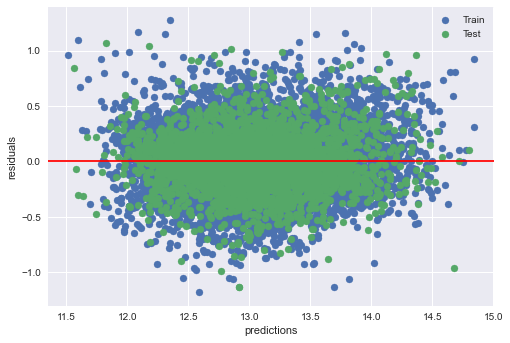



Residual qq plot


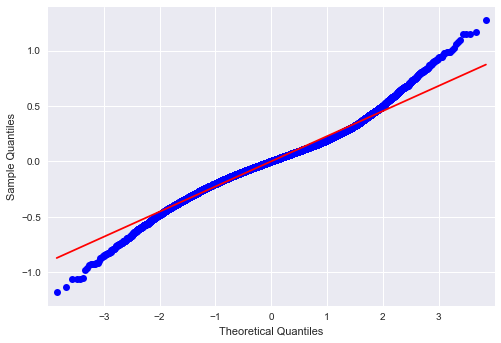

In [60]:
# Add in yard variable, year built categoricals (minus mid century), and interaction between pre 1970 and renovated

cols4 = ['high_bathrooms', 'high_bedrooms', 'multi_story', 'grade', 'basement', 'condition',
        'size_vs_lot_log', 'bath_vs_bed_log', 'has_yard', 'pre_1970', 'recent_build',
        'pre_1970_renovated', 'sqft_living_log'] + [x for x in neighborhood_list if x != 'Snoqualmie']

model_output4, train_preds4, test_preds4 = run_model(df_train, df_test, cols4, True)

evaluate_model(df_train, df_test, cols4, True)

In [63]:
# There is high correlation between grade and sq ft living.

col4_coll_test = df_train[cols4]

high_corr_values4 = high_corr(col4_coll_test, 0.6)

high_corr_values4

,cc
pairs,
"(high_bathrooms, high_bathrooms)",1.000000
"(grade, sqft_living_log)",0.736981


### Grade * Sqft Living Interaction

- Below creates a new interaction variable between grade and Sqft Living
- Both are strong predictors, so we don't want to lose the predictive effect by dropping one to help multi-collinearity
- Keeping both in the model retains their importance while keeping business interpretability
- Interpreation of the new variable is that increasing both grade and size simultaneously is very important

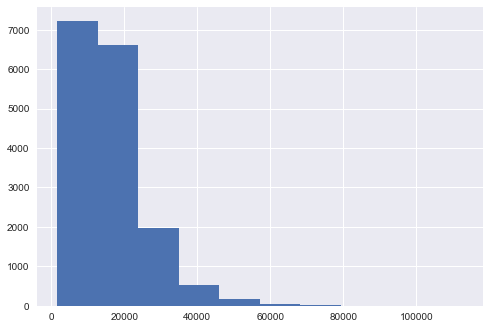

In [64]:
# Creating interaction between grade and size

df_train['grade_x_sqft_living'] = df_train['grade'] * df_train['sqft_living']
df_test['grade_x_sqft_living'] = df_test['grade'] * df_test['sqft_living']

# Check for normality and log new variable if needed
plt.hist(df_train['grade_x_sqft_living'])
plt.show();

In [65]:
# Log the new interaction variable

df_train['grade_x_sqft_living_log'] = np.log(df_train['grade_x_sqft_living'])
df_test['grade_x_sqft_living_log'] = np.log(df_test['grade_x_sqft_living'])

### Test the new Grade x Sqft Living Interaction variable

- Model performs slightly worse but the residuals show slightly more normalcy 

Train R2: 0.786
Test R2: 0.791
****
Train RMSE: 177,590
Test RMSE: 184,031
****
Train MAE: 94,970
Test MAE: 97,026

Residual scatter plot:


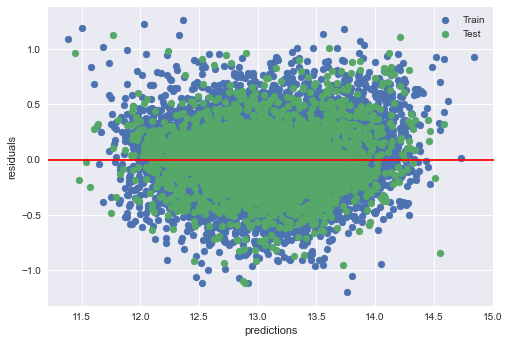



Residual qq plot


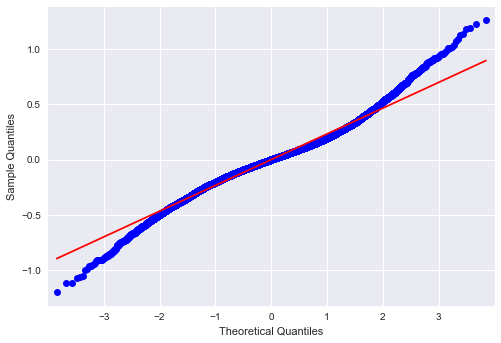

In [66]:
# Test new interaction variable

cols5 = ['high_bathrooms', 'high_bedrooms', 'multi_story', 'grade_x_sqft_living_log', 'basement', 'condition',
        'size_vs_lot_log', 'bath_vs_bed_log', 'has_yard', 'pre_1970', 'recent_build',
        'pre_1970_renovated'] + [x for x in neighborhood_list if x != 'Snoqualmie']

model_output5, train_preds5, test_preds5 = run_model(df_train, df_test, cols5, True)

evaluate_model(df_train, df_test, cols5, True)

### Add in view, remove bedroom and bathroom categoricals

- We haven't really touched on view as a predictor. 
- Given it's very non-normal distribution, we will create a categorical variable that's "good view" with a 1 if the house is a 3 or 4 on the 0-4 scale.
- Bedroom and bathroom categoricals were removed to help business understanding. There wasn't much real world justification for where we cut off "high bedroom" and "high bathroom".
- Bedrooms is now captured by original bedroom variable. Bathrooms is captured by bath vs. bed (bath divided by bed).
- Model performs reasonably well.
- No major multicollinearity issues (highest is 60%)

In [67]:
df_train['good_view'] = 0
df_test['good_view'] = 0

df_train['good_view'].loc[df_train['view'] >= 3] = 1
df_test['good_view'].loc[df_test['view'] >= 3] = 1

Train R2: 0.796
Test R2: 0.801
****
Train RMSE: 170,929
Test RMSE: 174,976
****
Train MAE: 93,019
Test MAE: 95,266

Residual scatter plot:


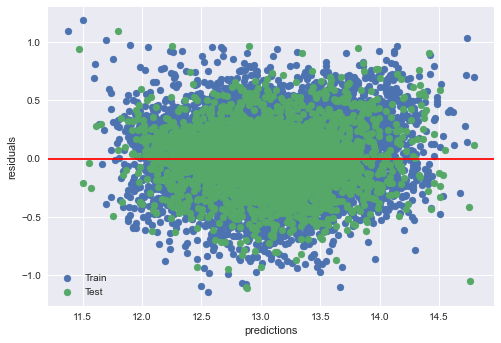



Residual qq plot


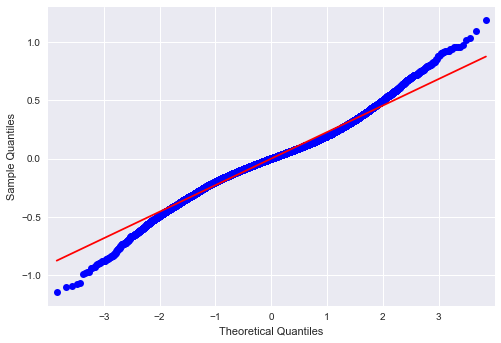

In [68]:
cols6 = ['bath_vs_bed_log', 'bedrooms', 'multi_story', 'grade_x_sqft_living_log', 'basement', 'condition',
        'size_vs_lot_log', 'has_yard', 'pre_1970', 'recent_build',
        'pre_1970_renovated', 'good_view'] + [x for x in neighborhood_list if x != 'Snoqualmie']

model_output6, train_preds6, test_preds6 = run_model(df_train, df_test, cols6, True)

evaluate_model(df_train, df_test, cols6, True)

In [69]:
col6_coll_test = df_train[cols6]

high_corr_values6 = high_corr(col6_coll_test, 0.6)

high_corr_values6

,cc
pairs,
"(bath_vs_bed_log, bath_vs_bed_log)",1.000000
"(grade_x_sqft_living_log, bedrooms)",0.607157


### Condition x grade

- Final model made a couple tweeks
- Given performance of grade * living area, wanted to test grade * condition as well to see if that improved performance (without introducing collinearity)
- Also decided to replace 'bath_vs_bed_log' with just 'bath_vs_bed' to help interpretability of final model (reminder, this field is number of baths divided by number of beds)
- This model is up to 0.8 R2 without reasonably normal residuals and no collinearity issues
- This is likely as good as we'll get in the time alloted

In [70]:
df_train['grade_x_condition'] = df_train['grade'] * df_train['condition']
df_test['grade_x_condition'] = df_test['grade'] * df_test['condition']

### Final Model
- Zipcodes was slightly more predictive than our simple model, but ultimately, we opted for less accuracy to help with business understanding
- As our final model, we chose the model that combines several key features of the house along with neighborhood
- This produces an R2 of 0.8, with reasonable reproducability in our Test dataset
- The MAE is 92K, meaning on average, we're off by that amount from the actual sale price on average
- The model does a decent job of adhering to the rules of linear regression. There is no discernable trend in the scatter plot of the residuals. The QQ plot has issues at the extremes, but generally follows the 45 degree line.
- There is not significant multicollinearity among the independent variables. The most highly correlated is the interaction of sqft living area and grade vs. bedrooms at 0.6. This is generally below the rough threshold of 0.75 where you might expect to have signficant issues here.
- We believe we've taken all reasonable steps to address the linear regression rules, including log transforming variables without a normal distribution, dropping variables with high collinearity, and log transforming our dependent variable.

Train R2: 0.800
Test R2: 0.805
****
Train RMSE: 168,427
Test RMSE: 171,879
****
Train MAE: 92,071
Test MAE: 94,087

Residual scatter plot:


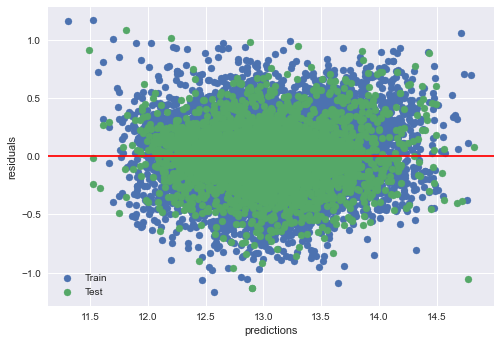



Residual qq plot


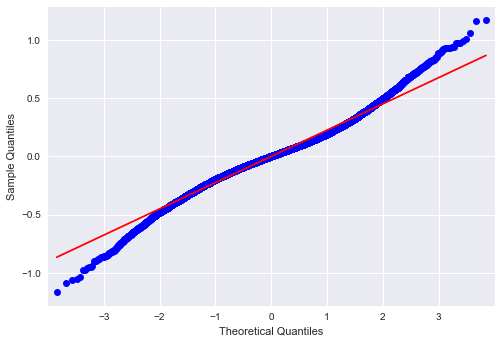

In [73]:
final_cols = ['bath_vs_bed', 'bedrooms', 'multi_story', 'grade_x_sqft_living_log', 'basement', 'grade_x_condition',
        'size_vs_lot_log', 'has_yard', 'pre_1970', 'recent_build', 'pre_1970_renovated',
        'good_view'] + [x for x in neighborhood_list if x != 'Snoqualmie']

final_output, final_train_preds, final_test_preds = run_model(df_train, df_test, final_cols, True)

evaluate_model(df_train, df_test, final_cols, True)

In [74]:
col7_coll_test = df_train[final_cols]

high_corr_values7 = high_corr(col7_coll_test, 0.6)

high_corr_values7

,cc
pairs,
"(bath_vs_bed, bath_vs_bed)",1.000000
"(bedrooms, grade_x_sqft_living_log)",0.607157


## Model normalization

- The below code normalizes all the columns of the model so the coefficients can be compared for better business understanding
- Given mix of categorical and continuous, we used the min-max scalar instead of the standard scaler

Conclusions:
- Coefficient for grade x sqft living and grade x condition are quite large
- Many neighborhoods appear at the top (and bottom) as meaningful predictors
- Having a view is a good predictor, although this can't really inform a business recommendation
- Living area vs. lot has a strong negative coefficient. This will help inform a recommendation about having a yard.
- Bath vs. bed has a strong positive relationship

Business Recommendations:
- Recommendation 1: Focus on properties with low grade or condition, because improving these results in a significantly higher price

- Recommendation 2: Neighborhood recommendation (top 5 from the below).

- Recommendation 3: Square footage is important, but taking up too much of a lot is bad. People value space and yard. So if you increase sq footage, focus on increasing number of stories.

In [75]:
# Use min max scalar with final model as a baseline to test normalizaiton

from sklearn.preprocessing import MinMaxScaler

scaler_test = MinMaxScaler()
scaler_train = MinMaxScaler()

scaler_test.fit(df_train[final_cols])
scaler_train.fit(df_test[final_cols])

df_train_scaled = pd.DataFrame(scaler_test.transform(df_train[final_cols]), columns=final_cols, index=df_train.index)
df_test_scaled = pd.DataFrame(scaler_test.transform(df_test[final_cols]), columns=final_cols, index=df_test.index)

df_train_scaled = pd.concat([df_train_scaled, df_train[['price', 'price_log']]], axis=1)
df_test_scaled = pd.concat([df_test_scaled, df_test[['price', 'price_log']]], axis=1)

In [77]:
# Test to ensure normalized model performs the exact same as the final model

model_output_norm, train_preds_norm, test_preds_norm = run_model(df_train_scaled, df_test_scaled, final_cols, True)

model_output_norm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     1440.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:13:34   Log-Likelihood:                 1022.0
No. Observations:               16554   AIC:                            -1950.
Df Residuals:                   16507   BIC:                            -1588.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  11.5537      0.025    471.162      0.000      11.506      11.602
bath_vs_bed                 0.1671      0.029      5.688      0.000       0.110       0.225
bedrooms                   -0.1076      0.014     -7.626      0.000      -0.135      -0.080
multi_story                 0.0250      0.005      5.045      0.000       0.015       0.035
grade_x_sqft_living_log     2.5694      0.028     91.620      0.000       2.514       2.624
basement                   -0.0398      0.005     -8.791      0.000      -0.049      -0.031
grade_x_condition           0.5586      0.022     25.686      0.000       0.516       0.601
size_vs_lot_log            -0.2219      0.019    -11.676      0.000      -0.259      -0.185
has_yard                    0.0130      0.007      1.846      0.065      -0.001       0.027
pre_1970                    0.0642      0.005     12.170      0.000       0.054       0.075
recent_build                0.0754      0.008      9.426      0.000       0.060       0.091
pre_1970_renovated          0.0897      0.011      8.210      0.000       0.068       0.111
good_view                   0.2919      0.010     28.134      0.000       0.272       0.312
Tukwila                    -0.3324      0.022    -15.380      0.000      -0.375      -0.290
Auburn                     -0.4127      0.019    -22.231      0.000      -0.449      -0.376
North_Bend                 -0.0701      0.023     -3.057      0.002      -0.115      -0.025
Vashon                     -0.0330      0.030     -1.104      0.270      -0.091       0.026
Union_Hill_Novelty_Hill     0.1794      0.020      8.982      0.000       0.140       0.219
Fall_City                   0.0527      0.036      1.476      0.140      -0.017       0.123
Fairwood                   -0.2436      0.019    -12.608      0.000      -0.282      -0.206
Bothell                     0.0322      0.024      1.370      0.171      -0.014       0.078
White_Center               -0.1191      0.022     -5.531      0.000      -0.161      -0.077
Kirkland                    0.2568      0.017     15.124      0.000       0.224       0.290
SeaTac                     -0.3183      0.027    -11.819      0.000      -0.371      -0.265
Lakeland_North             -0.4181      0.020    -20.929      0.000      -0.457      -0.379
Federal_Way                -0.4175      0.017    -23.897      0.000      -0.452      -0.383
Woodinville                 0.0836      0.022      3.824      0.000       0.041       0.126
Covington                  -0.3511      0.019    -18.933      0.000      -0.387      -0.315
Kent                       -0.3895      0.020    -19.535      0.000      -0.429      -0.350
Burien                     -0.1252      0.021     -6.016      0.000      -0.166      -0.084
Kenmore                    -0.0016      0.021  

In [78]:
# Create a dataframe of normalized coefficients, pvalues, and non-normalized coefficients

pd.options.display.float_format = '{:,.4f}'.format

col_list = ['Intercept'] + final_cols

coefficient_dict = {'variables': col_list, 'coefficients': model_output_norm.params.values}

params_df = pd.DataFrame.from_dict(coefficient_dict)
params_df.set_index('variables', inplace=True)

params_df['pvalue'] = model_output_norm.pvalues

params_df['coefficients_abs'] = np.abs(params_df['coefficients'])

params_df['unscaled_coeff']= final_output.params.values

In [80]:
params_df.sort_values('coefficients_abs', ascending=False)

,coefficients,pvalue,coefficients_abs,unscaled_coeff
variables,,,,
Intercept,11.5537,0.0000,11.5537,6.8914
grade_x_sqft_living_log,2.5694,0.0000,2.5694,0.6003
grade_x_condition,0.5586,0.0000,0.5586,0.0100
Lakeland_North,-0.4181,0.0000,0.4181,-0.4181
Federal_Way,-0.4175,0.0000,0.4175,-0.4175
Auburn,-0.4127,0.0000,0.4127,-0.4127
Kent,-0.3895,0.0000,0.3895,-0.3895
Enumclaw,-0.3760,0.0000,0.3760,-0.3760
Covington,-0.3511,0.0000,0.3511,-0.3511


## Slide Deck Visualizations

Below were used in final presentation

In [81]:
predictor_graph = params_df.loc[['grade_x_sqft_living_log', 'grade_x_condition', 'size_vs_lot_log', 'bath_vs_bed'], 'coefficients']
predictor_graph_neighborhoods = params_df.loc[['Bellevue', 'Seattle', 'Kirkland', 'Redmond'], 'coefficients']

In [95]:
# Summary of Medina and Mercer Island outliers

sales_clean_mean = sales_clean['price'].mean()
avgsale_data = [['Total Average', sales_clean_mean], ['Mercer Average', 1174230], ['Medina Average', 2056771]]
avgprice_df = pd.DataFrame(data=avgsale_data, columns=['Neighborhood', 'Average Sale Price'])
avgprice_df

,Neighborhood,Average Sale Price
0,Total Average,"521,744.3680"
1,Mercer Average,"1,174,230.0000"
2,Medina Average,"2,056,771.0000"


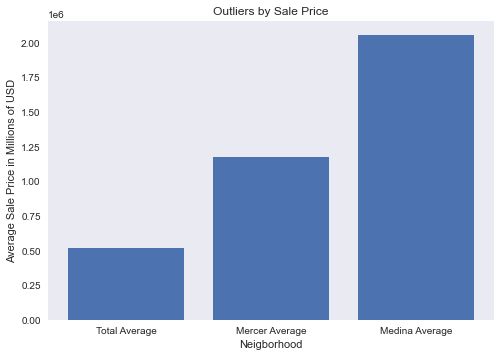

In [96]:
plt.bar(x=avgprice_df['Neighborhood'], height=avgprice_df['Average Sale Price'])
plt.xlabel('Neigborhood')
plt.ylabel('Average Sale Price in Millions of USD')
plt.title('Outliers by Sale Price')
plt.grid(False)

<ipython-input-84-a3e4b8814b4c>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y, fontsize=12, color='black')


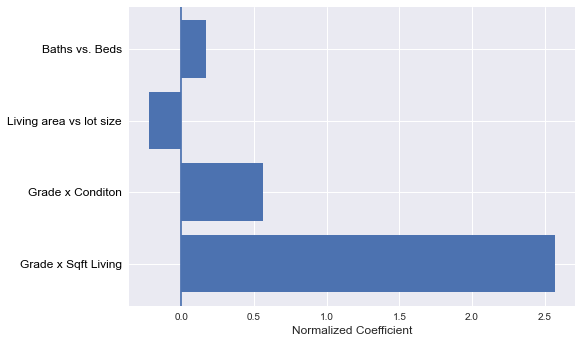

In [84]:
fig, ax = plt.subplots()

y = ['Grade x Sqft Living', 'Grade x Conditon', 'Living area vs lot size', 'Baths vs. Beds']

ax.barh(y = y, width = predictor_graph);
ax.set_yticklabels(y, fontsize=12, color='black')
ax.axvline(x=0, ymin=0, ymax=1)
ax.set_xlabel('Normalized Coefficient', fontsize=12)

plt.yticks(rotation = 0, wrap=True);
# predictor_graph

<ipython-input-86-37ac2bd3b5fb>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y, fontsize=12, color='black')


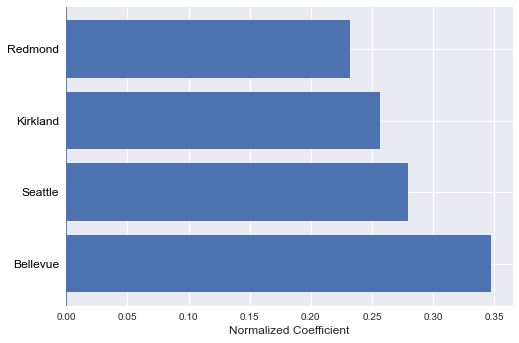

In [86]:
fig, ax = plt.subplots()

y = ['Bellevue', 'Seattle', 'Kirkland', 'Redmond']

ax.barh(y = y, width = predictor_graph_neighborhoods);
ax.set_yticklabels(y, fontsize=12, color='black')
ax.axvline(x=0, ymin=0, ymax=1)
ax.set_xlabel('Normalized Coefficient', fontsize=12)

plt.yticks(rotation = 0, wrap=True);

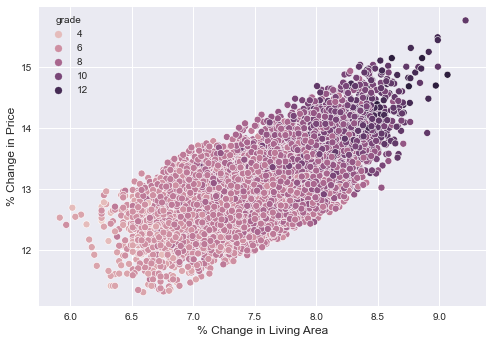

In [87]:
# Scatter plot of sq footage, log price, with grade as hue
fig, ax = plt.subplots()

sns.scatterplot(x='sqft_living_log', y='price_log', data=df_train, hue='grade', ax=ax);
ax.set_xlabel('% Change in Living Area', fontsize=12)
ax.set_ylabel('% Change in Price', fontsize=12);

In [88]:
top_neighborhoods = ['Bellevue', 'Seattle', 'Kirkland', 'Redmond']

neighborhood_list = []
for i in df_train['neighborhood']:
    if i in top_neighborhoods:
        neighborhood_list.append(1)
    else:
        neighborhood_list.append(0)
        
df_neighborhood = df_train.copy()

df_neighborhood['top_neighborhood'] = neighborhood_list

# Repeat above only for most impactful neighborhoods

df_neighborhood = df_neighborhood[df_neighborhood['top_neighborhood'] == 1]

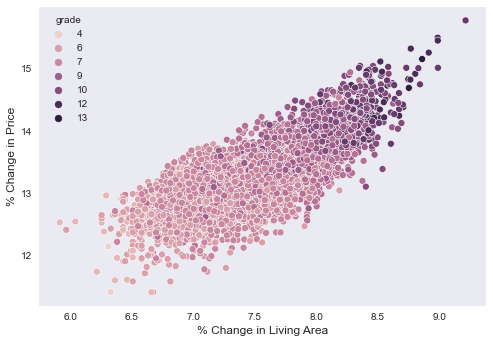

In [89]:
# Scatter plot for top neighborhoods and grade

fig, ax = plt.subplots()

sns.scatterplot(x='sqft_living_log', y='price_log', data=df_neighborhood, hue='grade', ax=ax);
ax.set_xlabel('% Change in Living Area', fontsize=12)
ax.set_ylabel('% Change in Price', fontsize=12)
ax.grid(False);

In [91]:
# Find % change in adding an extra bathroom. Plot in bar chart
bedroom_2 = df_train[df_train['bedrooms'] == 2]

bedroom_2_bath_1 = bedroom_2[bedroom_2['bathrooms'] == 1]
bedroom_2_bath_2 = bedroom_2[bedroom_2['bathrooms'] == 2]

mean1 = bedroom_2_bath_1['price'].mean()
mean2 = bedroom_2_bath_2['price'].mean()

(mean2 - mean1) / mean1

0.2939961097708744

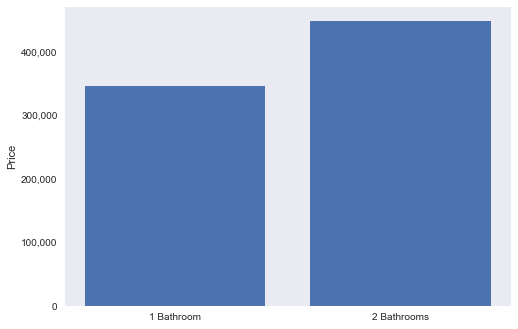

In [92]:
fig, ax = plt.subplots()

height = [bedroom_2_bath_1['price'].mean(), bedroom_2_bath_2['price'].mean()]

x = ['1 Bathroom', '2 Bathrooms']

ax.bar(x=x, height=height)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('Price')
ax.grid(False);

In [93]:
# Plot for having big yard or not

big_yard = df_train[df_train['living_area_vs_lot'] < 0.5]
small_yard = df_train[df_train['living_area_vs_lot'] >= 0.5]

(big_yard['price'].mean() - small_yard['price'].mean()) / small_yard['price'].mean()

0.13563081189333126

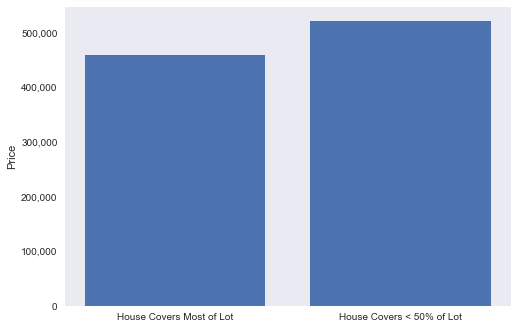

In [94]:
fig, ax = plt.subplots()

height = [small_yard['price'].mean(), big_yard['price'].mean()]

x = ['House Covers Most of Lot', 'House Covers < 50% of Lot']

ax.bar(x=x, height=height)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('Price')
ax.grid(False);

## Conclusions

Ultimately, we were able to produce a reasonably predictive model while keep several features that could help inform actionable business recommendations.

These recommendations are:
- Focus on buying low quality, small homes in [insert list of neighborhoods here] as grade and size are very important drivers of increased price
- But don't build too big! Sq ft of the living area vs. lot size has a very negative relationship with price. People like their lawns. If you're going to increase the square footage of the house, build up, not out.

Next steps:
- There is nothing in this dataset with regards to profitability. While we suggest improving the grade (quality) of the house is a meaningful way to increase price, we can't say how expensive those changes are to implement. The next step would be to incorporate expenses into the model so that the outcome could be some expense-adjusted measure of price.
- There is no time element to the dataset. It only includes home sales from September to January for a single year. There is not enough data to concluce whether waiting to sell in a particular season or time of year is beneficial. We'd like to expand the dataset to do a temporal analysis across multiple years